In [104]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

# import plt
import matplotlib.pyplot as plt


In [105]:
# Set the directory containing the images
input_directory = "data"

# add to grey
transform = transforms.Compose([transforms.Resize(100),
                                 transforms.Grayscale(num_output_channels=1),
                                 transforms.ToTensor()])

dataset = datasets.ImageFolder(input_directory, transform=transform)

# Get the class labels and split the dataset into train and test sets
class_labels = dataset.classes
train_dataset, test_dataset = train_test_split(dataset, test_size=0.25, random_state=42)

# Print the number of samples in each split
print("Train set size:", len(train_dataset))
print("Test set size:", len(test_dataset))



# Create data loaders
batch_size = 24 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train set size: 192
Test set size: 64


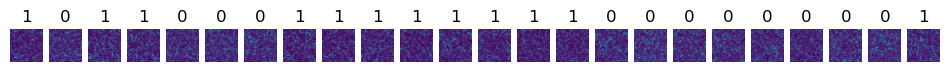

In [106]:
# show the images from the first batch with their labels
for images, labels in train_loader:
    # big figure
    fig, ax = plt.subplots(1, len(images), figsize=(12, 12))
    for i, image in enumerate(images):
        ax[i].imshow(image[0])
        ax[i].set_title(labels[i].item())
        ax[i].axis('off')
    break

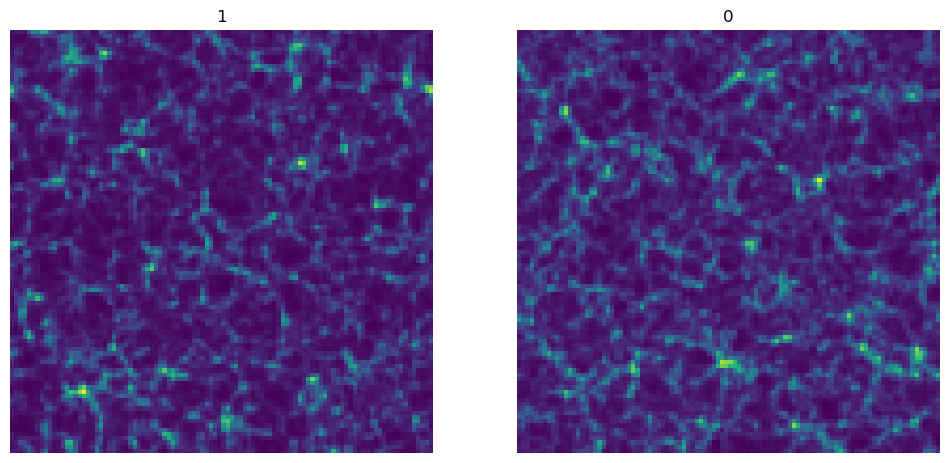

In [107]:
# show jyst two images
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(images[0][0])
ax[0].set_title(labels[0].item())
ax[0].axis('off')
ax[1].imshow(images[1][0])
ax[1].set_title(labels[1].item())
ax[1].axis('off')
plt.show()

In [108]:
# get dimension
print(images[0].shape)

torch.Size([1, 100, 100])


In [109]:
# define the model
# this is a VAE model
# for the encoder, two Conv2d layers are used to extract features from the input image
# the output image is of size 1x100x100
# first have 32 filters and kernel size 4, stride 2, padding 1
# second have 64 filters and kernel size 4, stride 2, padding 1
# then the output is flattened 
# the latent space is represented by two vectors, mean and logvar, dimension 2

# for the decoder, the latent space is first passed through a linear layer to get a tensor of size 64
# then reshaped to a tensor of size 64x1x1
# then passed through two ConvTranspose2d layers to get the output image
# first have 64 filters and kernel size 4, stride 2, padding 1
# second have 32 filters and kernel size 4, stride 2, padding 1
# the output image is of size 1x100x100

class VAE(torch.nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Flatten()
        )
        self.fc1 = torch.nn.Linear(64*25*25, latent_dim)
        self.fc2 = torch.nn.Linear(64*25*25, latent_dim)
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 64*25*25),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (64, 25, 25)),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            torch.nn.Sigmoid()
        )
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc1(x)
        logvar = self.fc2(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [110]:
# define the model
latent_dim = 2
model = VAE(latent_dim)

# define the loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = torch.nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [111]:
# test the model
reconst, mu, logvar = model(images)

In [112]:
# train the model
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, (images, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_images, mu, logvar = model(images)
        loss = loss_function(recon_images, images, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss {train_loss/len(train_loader.dataset)}')

Epoch 0, Loss 4570.9814046223955
Epoch 1, Loss 3639.091756184896
Epoch 2, Loss 3575.6661376953125
Epoch 3, Loss 3547.3475748697915
Epoch 4, Loss 3530.7281901041665
Epoch 5, Loss 3518.9390869140625
Epoch 6, Loss 3509.899658203125
Epoch 7, Loss 3502.986857096354
Epoch 8, Loss 3496.7618408203125
Epoch 9, Loss 3491.6448974609375
Epoch 10, Loss 3487.3297119140625
Epoch 11, Loss 3483.3338623046875
Epoch 12, Loss 3479.7369791666665
Epoch 13, Loss 3477.3776041666665
Epoch 14, Loss 3474.1612548828125
Epoch 15, Loss 3472.071085611979
Epoch 16, Loss 3469.9977213541665
Epoch 17, Loss 3468.0460205078125
Epoch 18, Loss 3466.4292805989585
Epoch 19, Loss 3464.9319661458335
Epoch 20, Loss 3463.6813151041665
Epoch 21, Loss 3463.069132486979
Epoch 22, Loss 3461.8126627604165
Epoch 23, Loss 3460.2979329427085
Epoch 24, Loss 3459.680419921875
Epoch 25, Loss 3458.80078125
Epoch 26, Loss 3457.79931640625
Epoch 27, Loss 3457.420939127604
Epoch 28, Loss 3457.02587890625
Epoch 29, Loss 3456.4471028645835
Epoch 

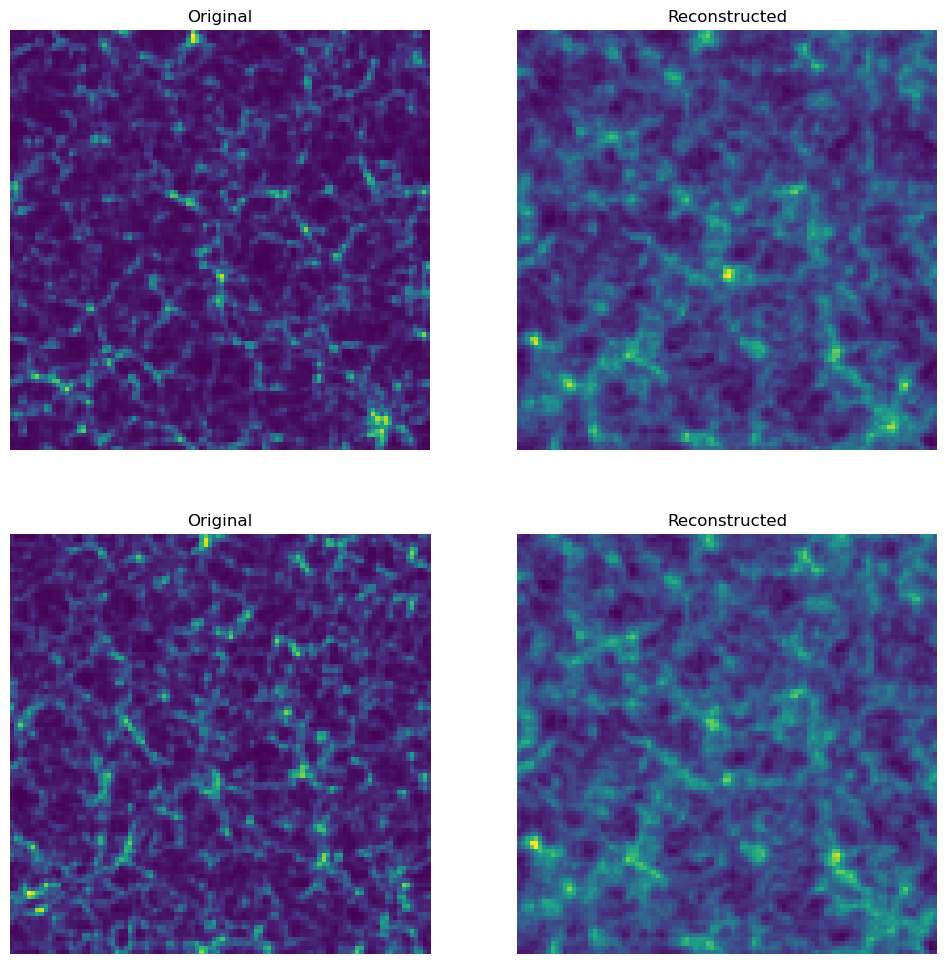

In [113]:
# show original and reconstructed images of the first two images in the test set
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        recon_images, _, _ = model(images)
        plt.figure(figsize=(12, 12))
        for i in range(2):
            plt.subplot(2, 2, i*2+1)
            plt.imshow(images[i][0])
            # add labels and title
            plt.title('Original')
            plt.axis('off')
            plt.subplot(2, 2, i*2+2)
            plt.imshow(recon_images[i][0])
            # add labels and title
            plt.title('Reconstructed')
            plt.axis('off')
        break

In [114]:
# plot the latent space of the train set

model.eval()
latent_vectors = []
categories = [] 

for images, labels in test_loader:
    _, mu, _ = model(images)
    latent_vectors.append(mu.detach().numpy())
    categories.append(labels.detach().numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
categories = np.concatenate(categories, axis=0)

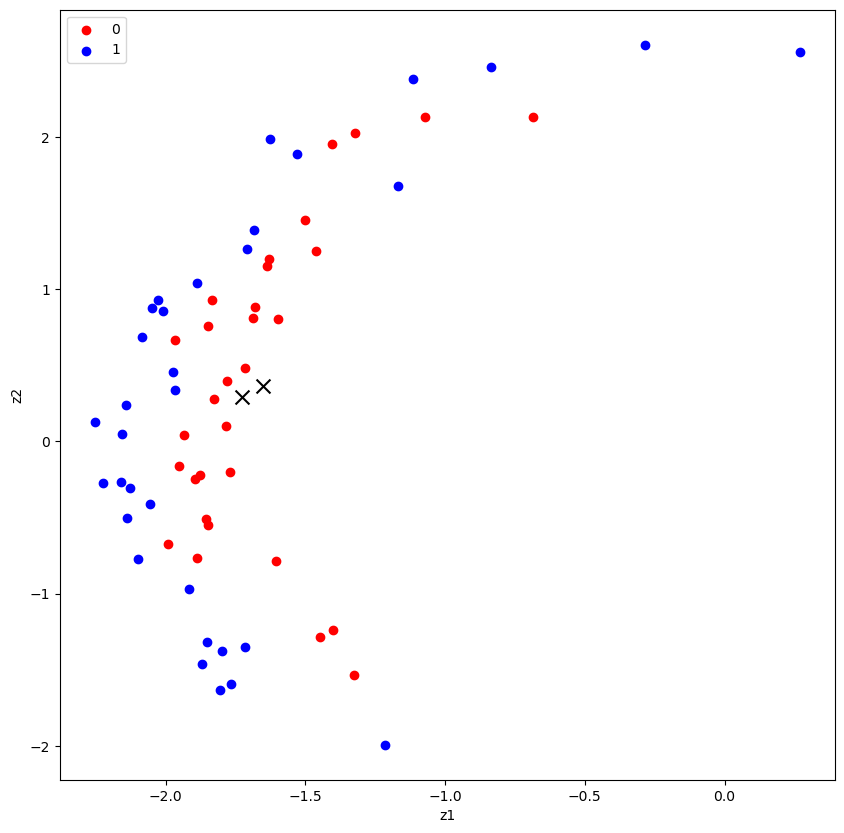

In [117]:
plt.figure(figsize=(10, 10))
plt.scatter(latent_vectors[categories==0, 0], latent_vectors[categories==0, 1], label='0', color='red')
plt.scatter(latent_vectors[categories==1, 0], latent_vectors[categories==1, 1], label='1', color='blue')

# get the mean on 1 and 9
mean_0 = np.mean(latent_vectors[categories==0], axis=0)
mean_1 = np.mean(latent_vectors[categories==1], axis=0)

plt.scatter(mean_0[0], mean_0[1], color='black', marker='x', s=100)
plt.scatter(mean_1[0], mean_1[1], color='black', marker='x', s=100)

# add labels
plt.xlabel('z1')
plt.ylabel('z2')

# add legend
plt.legend()


In [115]:
# get the mean of the latent vectors for the two categories
mean_latent_vectors = np.zeros((len(class_labels), latent_dim))
std_latent_vectors = np.zeros((len(class_labels), latent_dim))

for i in range(len(class_labels)):
    mean_latent_vectors[i] = np.mean(latent_vectors[categories == i], axis=0)
    std_latent_vectors[i] = np.std(latent_vectors[categories == i], axis=0)
    # print the mean and std
    print(f'Category {class_labels[i]}')
    print(f'Mean: {mean_latent_vectors[i]}')
    print(f'Std: {std_latent_vectors[i]}')


Category mu0_-1
Mean: [-1.65213227  0.3631255 ]
Std: [0.28409988 1.01119673]
Category mu0_1
Mean: [-1.72621155  0.2900354 ]
Std: [0.55391735 1.34140778]


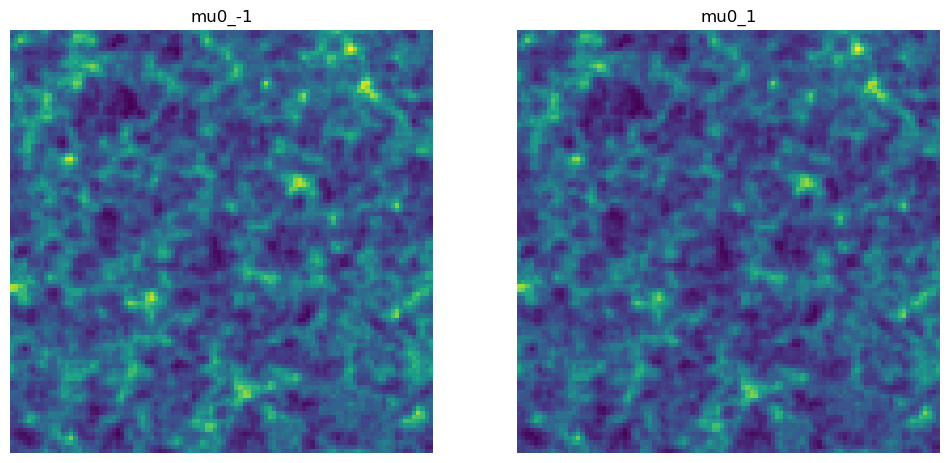

In [116]:
# generate image from the mean latent vector, there are onlty two categories
model.eval()

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
with torch.no_grad():
    z = torch.tensor(mean_latent_vectors[0]).float()
    z = z.unsqueeze(0)
    recon_image = model.decoder(z)
    plt.imshow(recon_image[0][0])
    plt.title(class_labels[0])
    plt.axis('off')
plt.subplot(1, 2, 2)
with torch.no_grad():
    z = torch.tensor(mean_latent_vectors[1]).float()
    z = z.unsqueeze(0)
    recon_image = model.decoder(z)
    plt.imshow(recon_image[0][0])
    plt.title(class_labels[1])
    plt.axis('off')

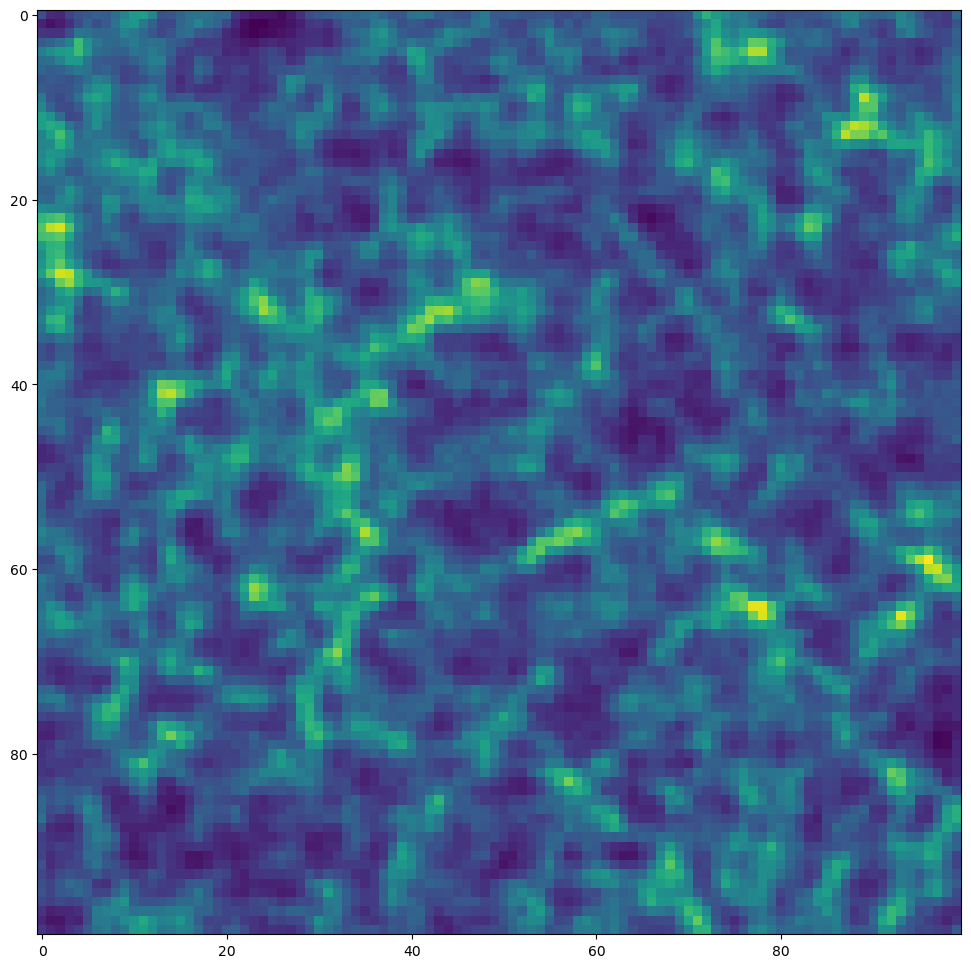

In [119]:
# generate the image from z0, z1 = 0, -1.7
model.eval()

with torch.no_grad():
    plt.figure(figsize=(12, 12))
    gen_image = model.decoder(torch.tensor([0, -1.7]).float().unsqueeze(0))
    plt.imshow(gen_image[0][0])